# Map Making

In this lesson we cover the mapmaking problem and current and available TOAST mapmaking facilities
* `OpMadam` -- interface to `libMadam`, a parallel Fortran library for destriping and mapping signal
* `OpMapmaker` -- nascent implementation of a native TOAST mapmaker with planned support for a host of systematics templates

In [1]:
# Load tools
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    fake_focalplane
)

import toast
import toast.todmap
import toast.pipeline_tools
from toast.mpi import MPI

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import matplotlib as mpl
import re

import todgb

mpiworld, procs, rank = toast.mpi.get_world()
comm = toast.mpi.Comm(mpiworld)
# A pipeline would create the args object with argparse

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

--------------------------------------------------------------------------
[[24234,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: socmb01

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------


Required Files:
Txt file of table for the following: 
Zp (pointing in 3d space)
fp (position on the focal plane)
Angle (detector polarization angle)

These should have three columns: 
#Npix (detector number), x, y and z coordinates (Zp), x and y coordinates (fp), or angle on focal plane and sky angle (angle).

These should be separated by spaces and not commas.

--
We also need weather files in the form of .fits:
A writing module for this weather file has all needed information on the format. I have included an excerpt here:

We take measurements made 24 times a day, (# of days) times a year at the relevant location. The file format required in the toast atmospheric simulation is .fits. A completed .fits file will have 12 (+ 1 primary, which is not used so you can make it whatever you want) layers called hdus, and in each of them we have 3D tables where the axes are Time (length 24), Variables (length 9), iCDF's domain (length 101). An iCDF is the inverse of a cumulative distribution function of the probability density function that each variable follows. The cumulative distribution function's value follows a uniform distribution in the interval [0,1]. The variables required in the final format are: TQI, TQL, TQV, QV10M, PS, TS, T10M, U10M, V10M.

** Also, the todgb library is required to get detector pointings for the GB scan. 

# Obtaining Data for Simulation (relevant to the site and telescope)

## Definition of input variables needed for observation data

### Focal Plane

In [2]:
# Recall information on the GB focal plane. (written by Seongsu Kim)
Zp = np.genfromtxt('../04_Simulated_Instrument_Signal/Zp.txt', delimiter = '\t')
fp = np.genfromtxt('../04_Simulated_Instrument_Signal/fp.txt', delimiter = '\t')
angle_array = np.genfromtxt('../04_Simulated_Instrument_Signal/angle.txt', delimiter = '\t')

In [3]:
# If you want to select a smaller number of detectors to run the simulation
# more quickly, you can use any of the following:

#Input detector information for selected few detectors
# [number, Zpx, Zpy, Zpz] pointing in 3d space 
# [number, fpx, fpy] position on focal plane
# [number, fp angle, sky angle] polarization angles
ListZp1 = [1,-0.0272211,0.0311863,0.999143] # Detectors nos. 5 and 6
ListZp2 = [6,-0.0135674,0.023398,0.999634]
Listfp1 = [1,-15.6,13.51] 
Listfp2 = [6,11.7,6.755]
Listangle1 = [1,-22.5,-22.8042]
Listangle2 = [6,22.5,22.7159]
#Zp_ = np.array([np.array(ListZp1),np.array(ListZp2)])
#fp_ = np.array([np.array(Listfp1),np.array(Listfp2)])
#angle_array_ = np.array([np.array(Listangle1),np.array(Listangle2)])

# Or you could construct a text file with relevant info and simply call them.
Zp_ = np.genfromtxt('../04_Simulated_Instrument_Signal/Zpalt.txt', delimiter = '\t')
fp_ = np.genfromtxt('../04_Simulated_Instrument_Signal/fpalt.txt', delimiter = '\t')
angle_array_ = np.genfromtxt('../04_Simulated_Instrument_Signal/anglealt.txt', delimiter = '\t')

In [4]:
GBF = [Zp,fp,angle_array]
Sample = [Zp_,fp_,angle_array_]

### Weather

In [5]:
Tw = "../04_Simulated_Instrument_Signal/weather_Tenerife.fits"
Aw = "../04_Simulated_Instrument_Signal/weather_Atacama.fits"

## Input Station

### Focal Plane

In [6]:
wh = GBF  # Which focal plane layout?

### Weather

In [7]:
wf = Tw  # Weather File

### GB Scan Parameters

In [8]:
sr = 113  # sample rate of the detectors (per second)
scandur = '10 Minutes' #Scan duration,format: 'N Day(Days) N Hour(Hours) N Minute(Minutes) N Second(Seconds)'
scr = 120  # scan rate, degrees per second
sc_ac = 0 # scan acceleration
SetBaseline = 10

In [9]:
def readtime(scandur):
    sday = (re.findall(r"(\d+) Day", scandur))
    shour = (re.findall(r"(\d+) Hour", scandur))
    sminute = (re.findall(r"(\d+) Minute", scandur))
    ssecond = (re.findall(r"(\d+) Seconds", scandur))

    slist = [sday,shour,sminute,ssecond]
    nlist = [0,0,0,0]
    for i in range(0,3):
        if len(slist[i])== 0:
            nlist[i] = 0
        else:
            nlist[i] = int((slist[i])[0])

    nday,nhour,nminute,nsecond = nlist
    t_ = nday*24*60*60 + nhour*60*60 + nminute*60 + nsecond # Scan duration in the unit of seconds
    return t_

t_ = readtime(scandur)

### Noise scale related parameters

In [88]:
### Play with Scale. 

# Detector Noise Factos
NET = 12 #GB: 12, TOAST default: 1
FKnee = 0.1 #GB: 0.1, TOAST default: 0.05

# Gain of signal and atmospheric noise (through the detector)
Gain = 3e-5*(10**(6)) # 3e-5 times the factor e+6, because the atmospheric noise is given by K, not muK.
    # This gain was calibrated against POLARBEAR data (3e-5) # the result should be considered along with this factor
    # ratio when converting signal to voltage.

## Data Class Writing Function

In [89]:
def FocPlane(w):
    Zp,fp,angle_array = w[0],w[1],w[2]
    # set unit vector
    z_vec = np.array([0,0,1])
    y_vec = np.array([0,1,0])
    data_len = len(Zp.T[0])

    Zp_vector = (Zp.T[1:]).T
    for i in range(data_len):
        Zp_vector[i] = Zp_vector[i]/np.sqrt(np.dot(Zp_vector[i],Zp_vector[i]))
        
    # angle theta
    # data_len = 2
    theta = np.zeros(data_len)
    theta_print = np.zeros(data_len)
    for i in range(data_len):
        theta[i] = np.dot(z_vec,Zp_vector[i])
        theta_print[i] = np.rad2deg(np.arccos(theta[i]))
        theta[i] = np.arccos(theta[i])
        theta_print[i] = round(theta_print[i],2)
        
    # build focalplane in length scale
    diff_angle = angle_array.T[2]-angle_array.T[1]
    color = diff_angle + max(diff_angle)
    x_fp = fp.T[1]
    y_fp = fp.T[2]
    c_fp = fp.T[0]
    
    # angle phi
    # project Zp onto xy plane (Zp_z = 0)
    Zp_proj = np.zeros((data_len,3))
    for i in range(data_len):
        Zp_proj[i][0] = Zp_vector[i][0]
        Zp_proj[i][1] = Zp_vector[i][1]
    # normalize
    for i in range(data_len):
        Zp_proj[i] = Zp_proj[i]/np.sqrt(np.dot(Zp_proj[i],Zp_proj[i]))
        
    phi = np.zeros(data_len)
    phi_print = np.zeros(data_len)
    for i in range(data_len):
        phi[i] = np.dot(y_vec,Zp_proj[i])
        if Zp_proj[i][0] < 0:
            phi[i] = np.arccos(phi[i])
        else:
            phi[i] = -np.arccos(phi[i])
        phi_print[i] = round(np.rad2deg(phi[i]),2)
    
    # build quaternion
    pa = np.pi/8
    # pa = 0

    # find index
    if data_len>10:
        left = [6,7,8,9,15,16,17,18,29,30,31,32,41,40,39,38,55,54,53,52,64,63,62,61,78,77,76,75,
                87,86,85,84,101,100,99,98,110,109,108,107,124,123,122,121,133,132,131,130,147,146,
                145,144,156,155,154,153]
        all = np.linspace(0,161,162)
        right = []
        for i in range(data_len):
            if i not in left:
                right.append(i)
    else:
        left, right =[],[]
        for i in range(data_len):
            #print("angle_array")
            #print(angle_array[i])
            if angle_array[i][1]<0:
                right.append(i),
            else: left.append(i)
                
    print(left)
    print(right)
    
    import toast.qarray as qa
    quat = np.zeros((data_len,4))
    for i in range(data_len):
        if i in right:
            quat[i] = qa.from_angles(theta[i],phi[i],-np.pi/2-phi[i]-pa)
        else:
            quat[i] = qa.from_angles(theta[i],phi[i],-np.pi/2-phi[i]+pa)
    
    # build telescope dict
    tel_dict = {}
    detname = np.linspace(0,data_len-1,data_len)
    for i in range(data_len):
        detname[i] = int(detname[i])
    
    for i in range(data_len):
        name = 'det_{}'.format(i) # det_(index)
        tel_dict[name] = {
            'quat': quat[int(i)],
            'epsilon': 0,
            'rate': 1000,
            'alpha': 1,
            'NET': NET,
            'fmin': 0,
            'fknee': FKnee,
            'fwhm_arcmin': 30,
        }
        
    %matplotlib inline 
    ind = 1
    key = 'det_{}'.format(ind)

    # list of dict of detectors, sort(), 순서대로
    detnames = list(tel_dict.keys()) 

    # assign "qaut"(quaternion) value of fp[i] in i_th x
    detquat = {x: tel_dict[x]["quat"] for x in detnames} 
    detquat_ind = detquat[key]
    detquat_plot = {'{}'.format(key): detquat_ind}
    # print(detquat_plot)

    # assign "fwhm_arcmin" value of fp[i] in i_th x, 
    # fwhm, full width at half maximum
    detfwhm = {x: tel_dict[x]["fwhm_arcmin"] for x in detnames}
    detfwhm_ind = detfwhm[key]
    detfwhm_plot = {'{}'.format(key): detfwhm_ind}

    # labels
    detlabels = {x: x for x in detnames}
    detlabels_ind = detlabels[key]
    detlabels_plot = {'{}'.format(key): detlabels_ind}

    # ploariztion colors
    detpolcol = {x: "red" for i, x in enumerate(detnames)}
    
    #plot
    toast.tod.plot_focalplane(
        detquat, 20.0, 20.0, None,polcolor = detpolcol, fwhm=detfwhm, labels=detlabels 
    )
    
    global det_length
    det_length = len(tel_dict)
    return tel_dict


In [90]:
def MakeInputData(tel_dict,weatherfile,sr,t_,SCR):
    
    samplerate = sr
    time = t_
    # seconds
    sampleno = samplerate*time
    SCANrate = SCR
    # degrees per second
    # GB: 120
    
    #some MPI stuff
    mpiworld, procs, rank = toast.mpi.get_world()
    comm = toast.mpi.Comm(mpiworld)
    
    # Setup은 위에서 정의하고 setup 그대로 넣어주면 됨
    ! toast_ground_schedule.py \
        --site-lat "28.4746" \
        --site-lon "-16.3081" \
        --site-alt 2390 \
        --site-name Teide \
        --telescope LAT \
        --start "2020-03-20 10:30:00" \
        --stop "2020-03-20 11:30:00" \
        --patch-coord C \
        --patch small_patch,1,30,28,10 \
        --ces-max-time 86400 \
        --out schedule.txt

    ! cat schedule.txt
    
    class args:
        split_schedule = None
        schedule = "schedule.txt"
        sort_schedule = False  # Matters for parallelization
        weather = weatherfile #THIS IS WHERE THE WEATHER GOES
        #so the code won't run without it. We will leave it like this for the time being.
        sample_rate = 113  # Hz
        scan_rate = 120  # deg / s
        # Use an artifially low acceleration to show the turn-arounds better
        scan_accel = 0  # deg / s^2
        hwp_rpm = None
        hwp_step_deg = None
        hwp_step_time_s = None
        fov = 3.0  # Field-of-view in degrees
    
    focalplane = toast.pipeline_tools.Focalplane(
        tel_dict, sample_rate=args.sample_rate
    )
    
    # Load the observing schedule, append weather and focalplane to it 
    schedules = toast.pipeline_tools.load_schedule(args, comm)
    toast.pipeline_tools.load_weather(args, comm, schedules)
    # There could be more than one observing schedule, but not this time
    schedule = schedules[0]
    schedule.telescope.focalplane = focalplane
    ces = schedule.ceslist[0]  # normally we would loop over entries
    totsamples = int((ces.stop_time - ces.start_time) * args.sample_rate)
    telescope = schedule.telescope  # shorthand
    
    #organize processes
    if comm.comm_group is not None:
        # Available detectors should be split between processes in the group
        ndetrank = comm.comm_group.size
    else:
        ndetrank = 1
    
    tod_ = toast.todmap.TODGround(
        comm.comm_group,
        telescope.focalplane.detquats,
        totsamples,
        detranks=ndetrank,
        firsttime=ces.start_time,
        rate=args.sample_rate,
        site_lon=telescope.site.lon,
        site_lat=telescope.site.lat,
        site_alt=telescope.site.alt,
        azmin=ces.azmin,
        azmax=ces.azmax,
        el=ces.el,
        scanrate=args.scan_rate,
        scan_accel=args.scan_accel,
        
        hwprpm=args.hwp_rpm,
        hwpstep=args.hwp_step_deg,
        hwpsteptime=args.hwp_step_time_s,
    )
    
    tod = todgb.TODGb(
        detectors=tel_dict,
        samples=sampleno, ############# 3 Variables out of which we input 2 and leave one blank (or fit it in redundantly)
        mpicomm=comm.comm_group,
        boresight_angle=0,
        firsttime=0.0,
        rate=samplerate, # May have to do with scanning time and stuff
        # ############# 3 Variables out of which we input 2 and leave one blank (or fit it in redundantly)
        site_lon=telescope.site.lon,
        site_lat=telescope.site.lat,
        site_alt=telescope.site.alt,
        el=60,
        scanrate=SCANrate, # May have to do with scanning time and stuff
        scan_accel=0.1, # May have to do with scanning time and stuff
        CES_start=None, ############# 3 Variables out of which we input 2 and leave one blank (or fit it in redundantly)
        CES_stop=None, ############# 3 Variables out of which we input 2 and leave one blank (or fit it in redundantly)
        sun_angle_min=90,
        sampsizes=None,
        sampbreaks=None,
        coord="C",
        report_timing=True,
        hwprpm=args.hwp_rpm,
        hwpstep=args.hwp_step_deg,
        hwpsteptime=args.hwp_step_time_s,
        sinc_modulation=False,
    )
    
    print('tod time')
    print(tod.local_times())
    
    return [tod,telescope,tod_,ces]


In [91]:
def DefineOBS_data(m):
    tod,telescope,tod_,ces = m[0],m[1],m[2],m[3]
    
    #some MPI stuff
    mpiworld, procs, rank = toast.mpi.get_world()
    comm = toast.mpi.Comm(mpiworld)
    
    obs = {}
    obs["name"] = "CES-{}-{}-{}-{}-{}".format(
        telescope.site.name, telescope.name, ces.name, ces.scan, ces.subscan
    )
    obs["tod"] = tod
    obs["baselines"] = None
    obs["noise"] = telescope.focalplane.noise
    obs["id"] = int(ces.mjdstart * 10000)
    obs["intervals"] = None # tod_.subscans
    obs["site"] = telescope.site
    obs["site_name"] = telescope.site.name
    obs["site_id"] = telescope.site.id
    obs["altitude"] = telescope.site.alt
    obs["weather"] = telescope.site.weather
    obs["telescope"] = telescope
    obs["telescope_name"] = telescope.name
    obs["telescope_id"] = telescope.id
    obs["focalplane"] = telescope.focalplane.detector_data
    obs["fpradius"] = telescope.focalplane.radius
    obs["start_time"] = ces.start_time
    obs["season"] = ces.season
    obs["date"] = ces.start_date
    obs["MJD"] = ces.mjdstart
    obs["rising"] = ces.rising
    obs["mindist_sun"] = ces.mindist_sun
    obs["mindist_moon"] = ces.mindist_moon
    obs["el_sun"] = ces.el_sun
    
    data = toast.Data(comm)
    data.obs.append(obs)
    
    ### Degubbing
    ### I mean Debugging
    
    #'''
    print('################################')
    #print(data.obs)
    print(len(data.obs))
    
    print('data.obs type : '+str(type(data.obs)))
    if type(data.obs)==list:
        if type(data.obs[0])==dict:
            print('data.obs keys : '+str(dict.keys(data.obs[0])))  
    print('data type='+str(type(data)))
    if type(data)==list:
        if type(data[0])==dict:
            print('data keys : '+str(dict.keys(data[0])))  
    
    #'''
        
    return [data,tod,obs]
# 'data' is of <class 'toast.dist.Data'>
# and 'data.obs' is a list whose items are <class 'dict'>

## Run the function that defines the data class

[6, 7, 8, 9, 15, 16, 17, 18, 29, 30, 31, 32, 41, 40, 39, 38, 55, 54, 53, 52, 64, 63, 62, 61, 78, 77, 76, 75, 87, 86, 85, 84, 101, 100, 99, 98, 110, 109, 108, 107, 124, 123, 122, 121, 133, 132, 131, 130, 147, 146, 145, 144, 156, 155, 154, 153]
[0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 34, 35, 36, 37, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 56, 57, 58, 59, 60, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 79, 80, 81, 82, 83, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 102, 103, 104, 105, 106, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 148, 149, 150, 151, 152, 157, 158, 159, 160, 161]


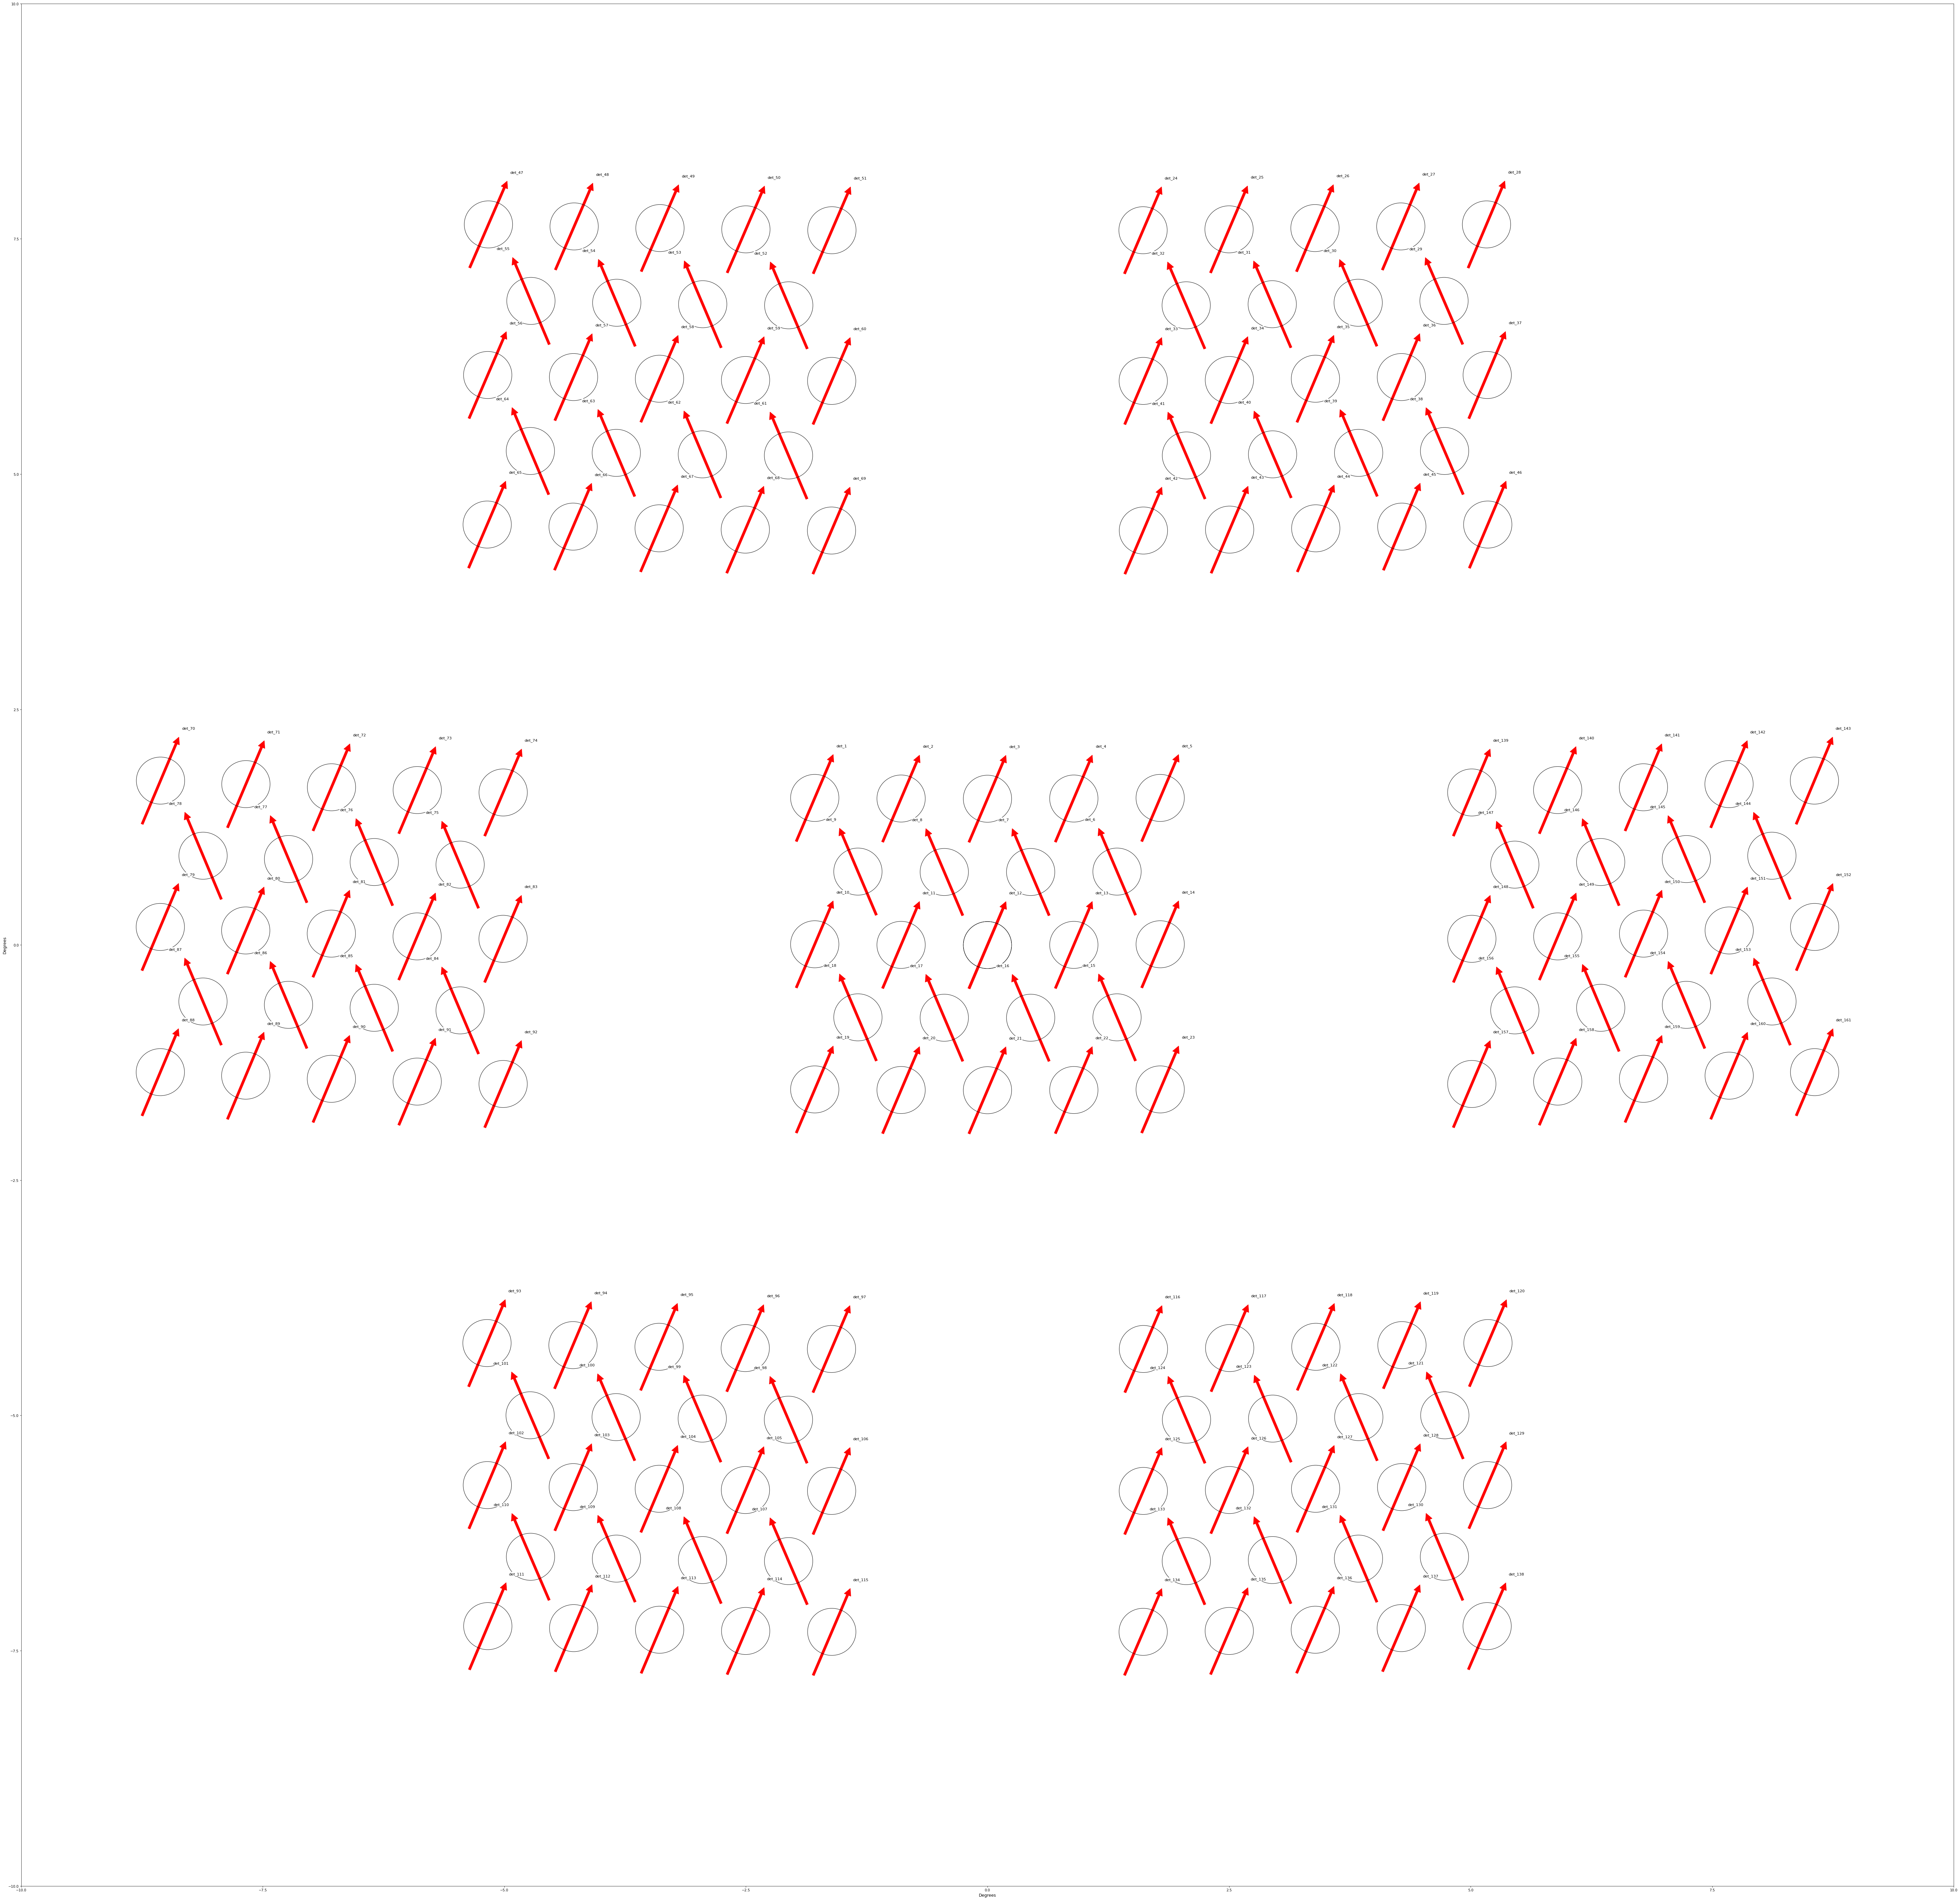

--------------------------------------------------------------------------
[[24234,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: socmb01

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Global timer: toast_ground_schedule:  0.04 seconds (1 calls)
#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Teide           LAT                      28.475         -16.308          2390.0
#      Start time UTC        Stop time UTC      Start MJD       Stop MJD Rotation Patch name                            Az min   Az max       El   R/S  Sun el1  Sun az1  Sun el2

/home/silee/.pyenv/versions/3.8.7/lib/python3.8/site-packages/toast/todmap/sim_tod.py:1507: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = t0 + 2 * dazdt / scan_accel
/home/silee/.pyenv/versions/3.8.7/lib/python3.8/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/silee/.pyenv/versions/3.8.7/lib/python3.8/site-packages/toast/todmap/sim_tod.py:1509: RuntimeWarning: invalid value encountered in multiply
  azvec = azmax + (tvec - t0) * dazdt - 0.5 * scan_accel * (tvec - t0) ** 2
/home/silee/.pyenv/versions/3.8.7/lib/python3.8/site-packages/toast/todmap/sim_tod.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = t0 + 2 * dazdt / scan_accel


TOAST INFO: TODGround: simulate scan:  0.05 seconds (1 calls)


/home/silee/.pyenv/versions/3.8.7/lib/python3.8/site-packages/numpy/core/function_base.py:134: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
/home/silee/.pyenv/versions/3.8.7/lib/python3.8/site-packages/toast/todmap/sim_tod.py:1545: RuntimeWarning: invalid value encountered in subtract
  azvec = azmin - (tvec - t0) * dazdt + 0.5 * scan_accel * (tvec - t0) ** 2


TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.14 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.01 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
tod time
[0.00000000e+00 8.84955752e-03 1.76991150e-02 ... 5.99973451e+02
 5.99982301e+02 5.99991150e+02]
TOAST INFO: TODGround: translate scan pointing:  0.03 seconds (1 calls)
################################
1
data.obs type : <class 'list'>
data.obs keys : dict_keys(['name', 'tod', 'baselines', 'noise', 'id', 'intervals', 'site', 'site_name', 'site_id', 'altitude', 'weather', 'telescope', 'telescope_name', 'telescope_id', 'focalplane', 'fpradius', 'start_time', 'season', 'date', 'MJD', 'rising', 'mindist_sun', 'mindist_moon', 'el_sun'])
data type=<class 'toast.dist.Data'>


In [92]:
datatuple = DefineOBS_data(MakeInputData(FocPlane(wh),wf,sr,t_,scr))
data = datatuple[0]

# Mapmaking

## Mapmaking basics

(Apologies to the experts.  You can freely skip the basics if this is trivial to you)

### Binning a map

CMB experiments measure the Stokes I (intensity), Q and U linear polarization components in discrete sky pixels.  A detector pointed at sky pixels $p$ registers a linear combination of the three Stokes components:

$$
d_p = I_p + \eta \cdot (Q_p \cos 2\psi + U_p \sin 2\psi) + n,
$$

where $\eta$ is the polarization efficiency of the detector, $\psi$ is the polarization sensitive direction and $n$ is the noise.  $\psi$ depends on the intrinsic polarization angle of the detector, $\psi_0$, and the relative orientation of the focalplane and the sky, $\psi'$. Furthermore, if the detector is observing the sky through a half-wave plate (HWP), then the HWP angle, $\omega$ must also be accounted for:

$$
\psi = \psi_0 + \alpha + 2\omega
$$

Regardless of how $\psi$ is modulated ($\psi_0$, $\alpha$ or $\omega$), one needs a bare minimum of 3 observations at different angles, $\psi$, to solve for $m=[I, Q, U]^T$. We encode the pointing weights ($1$, $\eta\cdot\cos 2\psi$, $\eta\cdot\sin 2\psi$) in a pointing matrix:

$$
P = \begin{bmatrix}
1 & \eta\cos 2\psi_1 & \eta\sin 2\psi_1 \\
1 & \eta\cos 2\psi_2 & \eta\sin 2\psi_2 \\
 & ... & \\
1 & \eta\cos 2\psi_N & \eta\sin 2\psi_N \\
\end{bmatrix}
$$

A vector of samples drawn from $m$ is then

$$
d = P m
$$

and we can find a (generalized) least squares solution of $m$ as

$$
m = (P^T N^{-1} P)^{-1} P^T N^{-1} d,
$$

where we have accounted for non-trivial noise correlations in

$$
N = \langle n n^T \rangle.
$$

If each detector sample is subject to same, uncorrelated noise fluctuations, $N$ can be dropped.  This recovers the regular least squares solution.

An important special case of $P$ results when the angles $\psi$ differ by 45 degrees and come in sets of 4:

In [93]:
import numpy as np
psi = np.radians(np.arange(4) * 45)
print("psi =", np.round(psi, 2))
P = np.vstack([np.ones_like(psi), np.cos(2*psi), np.sin(2*psi)]).T
print("P = \n", np.round(P, 3))
invcov = np.dot(P.T, P)
print("P^T P = \n", np.round(invcov, 3))
cov = np.linalg.inv(invcov)
print("(P^T P)^{-1} = \n", np.round(cov, 3))

psi = [0.   0.79 1.57 2.36]
P = 
 [[ 1.  1.  0.]
 [ 1.  0.  1.]
 [ 1. -1.  0.]
 [ 1. -0. -1.]]
P^T P = 
 [[ 4. -0.  0.]
 [-0.  2.  0.]
 [ 0.  0.  2.]]
(P^T P)^{-1} = 
 [[ 0.25  0.   -0.  ]
 [ 0.    0.5  -0.  ]
 [-0.   -0.    0.5 ]]


The quantity $P^T P$ is proportional to the noise covariance between $IQU$.  It being diagonal means that the statistical error between them is uncorrelated.  The reciprocal condition number of the above matrix is 0.5 which is the theoretical maximum. Low condition number would indicate that the $IQU$ solution is degenerate.

The mapmaking formalism in this section can be generalised for multiple sky pixels.  Each sky pixel corresponds to its own $I$, $Q$ and $U$ columns in $P$.  If the noise matrix, $N$, is diagonal, the pixel covariance matrix, $P^T N^{-1} P$ is $3\times 3$ block diagonal with each pixel being solved independently.

### Destriping

[arXiv:0907.0367](https://arxiv.org/abs/0907.0367)

In its simplest form, the time-ordered data (TOD) can be described as sky signal and a noise term:

$$
d = Pm + n.
$$

An optimal solution of $m$ requires the sample-sample covariance of $n$.  For that to exist, the noise term needs to be stationary, which is often not the case in presence of systematics.  We may decompose $n$ into a set of systematics templates and the actual, stationary noise term:

$$
d = Pm + Fa + n.
$$

Maximum likelihood solution of the template amplitudes, $a$, follows from the *destriping equation*: 

$$
(F^T N^{-1} Z F + C_a^{-1})a = F^T N^{-1} Z d,
$$

where

$$
Z = \mathbf 1 - P(P^T N^{-1} P)^{-1} P^T N^{-1}
$$

is a projection matrix that removes the sky-synchronous part of the signal and

$$
C_a = \langle a a^T \rangle
$$

TOAST provides an interface to a destriping library, [libMadam](https://github.com/hpc4cmb/libmadam), which solves a version of the destriping equation where the templates in $F$ are disjoint steps of a step function. `libMadam` approximates that the covariance between the steps is stationary and can be calculated from the detector noise power spectral densities (PSDs). The remaining noise term, $n$ is approximated as white noise with a diagonal noise covariance, $N$.  Users can just have `libMadam` write out the destriped maps or continue processing the destriped TOD:

$$
d' = d - Fa
$$

The TOAST native mapmaker under development is designed to be more general.  Columns of the template matrix, $F$ can be populated with arbitrary forms, with or without an associated noise prior term, $C_a$.  The templates are MPI-aware so a template may span data across process boundaries (think orbital dipole or far sidelobes).

## Begin Mapmaking 

In this section we create a TOAST data object with simulated signal and noise and process the data into hit maps, pixels noise matrices and signal maps.

In [94]:
# Parameters related to resolution
nside_inputmap = 64
nside_mapmaking = 64
nnz_manual = 3 #expects 3

In [95]:
# Define arguments to execute mapmaker
class args:
    sample_rate = sr  # Hz
    scan_rate = scr  # deg / s
    scan_accel = sc_ac  # deg / s^2
    hwp_rpm = None
    hwp_step_deg = None
    hwp_step_time_s = None
    #spin_period_min = 0.05 
    #spin_angle_deg = 120*60
    #prec_period_min = 1000000 
    #prec_angle_deg = 0 
    coord = "E"
    nside = nside_mapmaking
    nnz = nnz_manual
    outdir = "maps"

## SIGNAL

This is the signal we would normally be trying to measure with GB.
For simulations we create a synthetic Gaussian map to scan as input signal.

## Input parameters for the simulated input signal

In [96]:
Whichmap = 'sim_map_fixed.fits' # 'sim_map.fits' to use a newly generated map, 'sim_map_fixed.fits' to use a premade map
SetHubble = 67 #Setting the cosmological parameter: Hubble Constant (km/s/Mpc)
SetUnit = 'muK' #of temperature
SetLmax = 1024 #Cf. Original input: 1024
InputType = 1 #0 for Gaussian CLS with arbitrary scale, 1 for CMB
InputNside = nside_inputmap
SetFWHM = np.radians(1) #can be set to 0 or np.radians(wanted value (orig. 1))

### Generate Angular Power Spectrum

In [97]:
# Here we create an angular power spectrum that has the properties of the CMB.
# CMB has a temperature fluctuation on the scale of 100 muK.

import camb
# given a cosmological parameter, this module gives you an angular power spectrum 
# (to use as input CMB signal)
pars = camb.CAMBparams()
pars.set_cosmology(H0 = SetHubble)

res = camb.get_results(pars)
clss = res.get_total_cls(lmax=SetLmax,CMB_unit=SetUnit,raw_cl=True)
Simulated_CMB = clss.T # output is L, [TT, EE, BB, TE]: and the required input for our signal is [TT, EE, BB, TE], L

# Alternative Input Signal (can be adjusted to whatever scale you want)
Lmax_Random = nside_mapmaking*2
Simulated_Random = np.zeros([4, Lmax_Random + 1])
Simulated_Random[0] = 1e0

Simulated_Input = np.array([Simulated_Random, Simulated_CMB])

/tmp/ipykernel_15042/957486498.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Simulated_Input = np.array([Simulated_Random, Simulated_CMB])


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


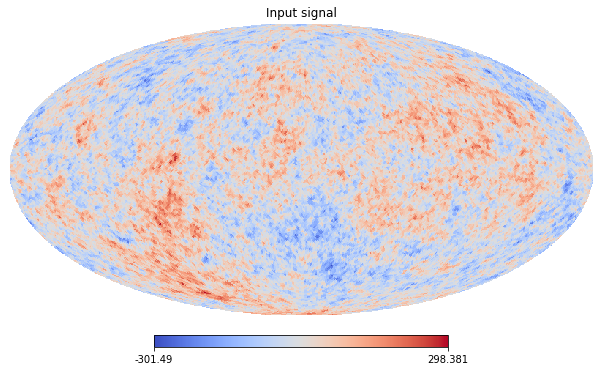

In [98]:
cls = Simulated_Input[InputType]
sim_map = hp.synfast(cls, InputNside, lmax=SetLmax, fwhm=SetFWHM, new=True)
### Input map is written as a nest!!!
hp.mollview(hp.reorder(sim_map[0],r2n=True), cmap="coolwarm", title="Input signal", nest=True)
hp.write_map("sim_map.fits", hp.reorder(sim_map, r2n=True), nest=True, overwrite=True)

## Get a Hitmap

0.0 180.0 -180.0 180.0


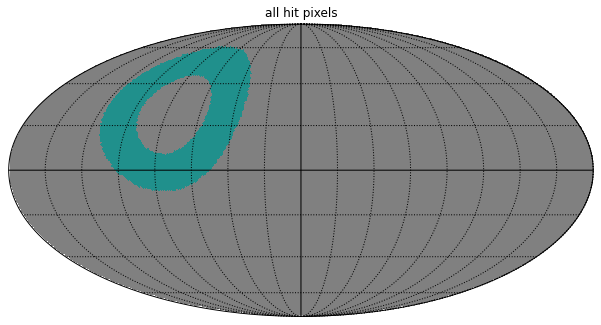

In [99]:
# Compute Pointing
name = "signal"
toast.tod.OpCacheClear(name).exec(data)
toast.todmap.OpPointingHpix(nside=args.nside, mode="IQU", nest=True).exec(data)

# Draw a map of detector pointing -- hitmap
npix = 12 * args.nside ** 2
hitmap = np.zeros(npix)
tod = data.obs[0]["tod"]
for det in tod.local_dets:
    pixels = tod.cache.reference("pixels_{}".format(det))
    hitmap[pixels] = 1
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, title="all hit pixels", nest=True, cbar=False)
hp.graticule(22.5, verbose=False)

# Alternative way of drawing a hitmap
#m = np.zeros(12*32*32)
#m[pixs] = 1
#np.where(m)
#hp.mollview(m, nest=True)

## Scan the signal

In [ ]:
# Clear cache
toast.tod.OpCacheClear(name).exec(data)

# Scan the signal from a map
distmap = toast.map.DistPixels(
    data,
    nnz=nnz_manual,
    dtype=np.float32,
)
distmap.read_healpix_fits("sim_map_fixed.fits")

toast.todmap.OpSimScan(input_map=distmap, out=name).exec(data)

# Copy the sky signal and define it as 'sky_signal'
toast.tod.OpCacheCopy(input=name, output="sky_signal", force=True).exec(data)

# Cf. OpCacheCopy: Operator which copies sets of timestreams between cache locations.
#This simply copies data from one set of per-detector cache objects to
#another set.  At some point we will likely move away from persistent
#caching of intermediate timestreams and this operator will become
#irrelevant.
#Args:
#        in (str): use cache objects with name <in>_<detector>.
#        out (str): copy data to the cache with name <out>_<detector>.
#            If the named cache objects do not exist, then they are created.
#        force (bool): force creating the target cache object.
        
# Simulate noise
#1. Instrument Noise
toast.tod.OpSimNoise(out=name, realization=0).exec(data)
toast.tod.OpCacheCopy(input=name, output="without_atmos", force=True).exec(data)

#2. Atmospheric Noise
#'''
atmsim = toast.todmap.OpSimAtmosphere(
        out=name,
        realization=0,  # Each MC will have a different realization
        zmax=1000,  # maximum altitude to integrate
        lmin_center=0.01,  # Dissipation scale
        lmin_sigma=0,
        lmax_center=10,  # Injection scale
        lmax_sigma=0,
        xstep=30, # Volume element size
        ystep=30,
        zstep=30,
        nelem_sim_max=10000,  # Target number of volume elements to consider at a time
        gain=Gain,  
        # If the wind is strong or the observation is long, the volume becomes
        # too large.  This parameter controls breaking the simulation into
        # disjoint segments
        wind_dist=10000,
        freq=100,  # Print progress to stdout and write out the correlation function
    )
atmsim.exec(data)
#'''

# Copy the augmented signal and define it as 'full_signal'
toast.tod.OpCacheCopy(input=name, output="full_signal", force=True).exec(data)
# After this, recalling 'tod.cache[name(e.g. 'full_signal')]' gives the corresponding tod.
# To see all keys: tod.cache.keys()

In [ ]:
detfreq = datatuple[2]['noise'].freq('det_0')
detpsd = datatuple[2]['noise'].psd('det_0')
plt.loglog(detfreq,detpsd)

In [ ]:
simdet = tod.cache['without_atmos_det_0']-tod.cache['sky_signal_det_0']
simatm = tod.local_signal(tod.local_dets[0],name)

plt.plot(tod.local_times(), simatm, "-", label = 'Atmosphere',color='#80E0FF')
plt.plot(tod.local_times(), simdet, "-", label = 'Detector',color='#FFB2F7')
plt.xlabel("Unix time [s]")
plt.ylabel("Atmosphere [\u03BCK]")
plt.title("Simulated Atmospheric Noise")
plt.grid()
print(max(simatm)-min(simatm))

## See raw TOD

In [ ]:
times = tod.local_times()

plt.plot(times, tod.cache['full_signal_det_0'],'-',label='with detector & atmospheric noise',color='#80E0FF')
plt.plot(times, tod.cache['without_atmos_det_0'],'-',label='with detector noise only',color='#80AAFF')
plt.plot(times, tod.cache['sky_signal_det_0'],'-',label='sky',color='#2C4F96')
plt.plot(times, tod.cache['full_signal_det_0']-tod.cache['signal_det_0'], '-', label="baselines",color='#FFB2F7',linewidth=2)
plt.legend(bbox_to_anchor=(1.1, 1.00))
plt.title('TOD: '+scandur)
plt.xlabel('time(s)')
plt.ylabel('signal(\u03BCK)')

# Simply to visually show the signal / noise components. 
# In an actual measurement, this is unnecessary.

Destripe the signal and make a map.  We use the nascent TOAST mapmaker because it can be run in serial mode without MPI.  The TOAST mapmaker is still significantly slower so production runs should used `libMadam`.

#  MAPMAKER
src/todmap/mapmaker.py

In [ ]:
mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=nnz_manual, 
    name=name,
    outdir=args.outdir,
    outprefix="toast_test_",
    baseline_length=SetBaseline,
    ### Where we cut into intervals for removing noise offset
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=100,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)
# This makes binned and destriped maps

## Show Noise TODs

Plot a segment of the timelines
Not a strictly necessary part of the mapmaking code

In [ ]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, "sky_signal")
    full = tod.local_signal(det, "full_signal")
    cleaned = tod.local_signal(det, name)

    ind = slice(0, 1000)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind], sky[ind], '.', label="sky", zorder=100)
    ax.plot(times[ind], full[ind] - sky[ind], '.', label="noise")
    ax.plot(times[ind], full[ind] - cleaned[ind], '.', label="baselines")
    ax.legend()
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)

In [ ]:
fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, "sky_signal")
    full = tod.local_signal(det, "full_signal")
    cleaned = tod.local_signal(det, name)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    #plt.plot(times[ind], sky[ind], '-', label="signal", zorder=100)
    plt.plot(times, full - sky, '.', label="noise")
    plt.plot(times, full - cleaned, '-', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=.6)
# Simply to visually show the signal / noise components. 
# In an actual measurement, this is unnecessary.

## Binned & Destriped Maps

In [ ]:
# See if the hitmap is written correctly
hitmap_ = hp.read_map("maps/toast_test_hits.fits",nest=True)
hitmap = hitmap = np.array(hitmap_, dtype='float')
hitmap[hitmap == 0] = hp.UNSEEN
a_ = int(np.sum(hitmap[hitmap != hp.UNSEEN]))
b_ = sr*t_*det_length
print('number of hits computed by hitmap: '+str(a_))
global det_length
print('number of hits computed manually: '+str(b_))
if not a_ == b_:
           print('There is a problem with pointing calculations.')

In [ ]:
# Set thresholds for display on the map (accordingly, considering the scale of the signal)
setmin = -330
setmax = 330

plt.figure(figsize=[12, 8])
plt.suptitle('\n'.join(['Simulated Maps',scandur+' Scan']),y=1.1)

hp.mollview(hp.reorder(hitmap,n2r=True), sub=[3, 2, 1], nest=False, title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits")
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[3, 2, 2], nest=False, title="binned map", cmap="coolwarm",min=setmin,max=setmax)

destriped = hp.read_map("maps/toast_test_destriped.fits")
destriped[destriped == 0] = hp.UNSEEN
hp.mollview(destriped, sub=[3, 2, 3], nest=False, title="destriped map", cmap="coolwarm",min=setmin,max=setmax)

inmap = hp.read_map(Whichmap)
inmap[hp.reorder(hitmap,n2r=True) == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[3, 2, 4], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)

inmap_whole = hp.read_map(Whichmap)
hp.mollview(inmap_whole, sub=[2, 3, 5], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)

In [ ]:
# Plot the white noise covariance
plt.figure(figsize=[12, 8])
wcov = hp.read_map("maps/toast_test_npp.fits", None)
wcov[:, wcov[0] == 0] = hp.UNSEEN
hp.mollview(wcov[0], sub=[3, 3, 1], title="II", cmap="coolwarm")
hp.mollview(wcov[1], sub=[3, 3, 2], title="IQ", cmap="coolwarm")
hp.mollview(wcov[2], sub=[3, 3, 3], title="IU", cmap="coolwarm")
hp.mollview(wcov[3], sub=[3, 3, 5], title="QQ", cmap="coolwarm")
hp.mollview(wcov[4], sub=[3, 3, 6], title="QU", cmap="coolwarm")
hp.mollview(wcov[5], sub=[3, 3, 9], title="UU", cmap="coolwarm")

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::

# Additional Simulations

## Without Atmospheric Noise

In [ ]:
# Clear cache
toast.tod.OpCacheClear(name).exec(data)

# Scan the signal from a map
distmap = toast.map.DistPixels(
    data,
    nnz=nnz_manual,
    dtype=np.float32,
)
distmap.read_healpix_fits(Whichmap)

toast.todmap.OpSimScan(input_map=distmap, out=name).exec(data)

# Copy the sky signal and define it as 'sky_signal'
toast.tod.OpCacheCopy(input=name, output="sky_signal", force=True).exec(data)

# Cf. OpCacheCopy: Operator which copies sets of timestreams between cache locations.
#This simply copies data from one set of per-detector cache objects to
#another set.  At some point we will likely move away from persistent
#caching of intermediate timestreams and this operator will become
#irrelevant.
#Args:
#        in (str): use cache objects with name <in>_<detector>.
#        out (str): copy data to the cache with name <out>_<detector>.
#            If the named cache objects do not exist, then they are created.
#        force (bool): force creating the target cache object.
        
# Simulate noise
#1. Instrument Noise
toast.tod.OpSimNoise(out=name, realization=0).exec(data)
#2. Atmospheric Noise: none

# Copy the augmented signal and define it as 'full_signal'
toast.tod.OpCacheCopy(input=name, output="full_signal", force=True).exec(data)
# After this, recalling 'tod.cache[name(e.g. 'full_signal')]' gives the corresponding tod.
# To see all keys: tod.cache.keys()


In [ ]:
times = tod.local_times()

plt.plot(times, tod.cache['full_signal_det_0'],'-',label='with detector noise',color='#80E0FF')
plt.plot(times, tod.cache['sky_signal_det_0'],'-',label='sky',color='#2C4F96')
plt.plot(times, tod.cache['full_signal_det_0']-tod.cache['signal_det_0'], '-', label="baselines",color='#FFB2F7',linewidth=2)
plt.legend(bbox_to_anchor=(1.1, 1.00))
plt.title('Scan TOD without Atmospheric Noise: '+scandur)
plt.xlabel('time(s)')
plt.ylabel('signal(\u03BCK)')

# Simply to visually show the signal / noise components. 
# In an actual measurement, this is unnecessary.

In [ ]:
mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=nnz_manual, 
    name=name,
    outdir=args.outdir,
    outprefix="toast_test_",
    baseline_length=10,
    ### Where we cut into intervals for removing noise offset
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=100,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)
# This makes binned and destriped maps

# See if the hitmap is written correctly
hitmap_ = hp.read_map("maps/toast_test_hits.fits",nest=True)
hitmap = hitmap = np.array(hitmap_, dtype='float')
hitmap[hitmap == 0] = hp.UNSEEN
a_ = int(np.sum(hitmap[hitmap != hp.UNSEEN]))
b_ = sr*t_*det_length
print('number of hits computed by hitmap: '+str(a_))
global det_length
print('number of hits computed manually: '+str(b_))
if not a_ == b_:
           print('There is a problem with pointing calculations.')

In [ ]:
# Set thresholds for display on the map (accordingly, considering the scale of the signal)
setmin = -330
setmax = 330

plt.figure(figsize=[12, 8])
plt.suptitle('\n'.join(['Simulated Maps',scandur+' Scan']),y=1.1)
hp.mollview(hp.reorder(hitmap,n2r=True), sub=[3, 2, 1], nest=False, title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits")
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[3, 2, 2], nest=False, title="binned map", cmap="coolwarm",min=setmin,max=setmax)

destriped = hp.read_map("maps/toast_test_destriped.fits")
destriped[destriped == 0] = hp.UNSEEN
hp.mollview(destriped, sub=[3, 2, 3], nest=False, title="destriped map", cmap="coolwarm",min=setmin,max=setmax)

inmap = hp.read_map(Whichmap)
inmap[hp.reorder(hitmap,n2r=True) == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[3, 2, 4], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)

inmap_whole = hp.read_map(Whichmap)
hp.mollview(inmap_whole, sub=[2, 3, 5], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)


## Longer Baseline

In [ ]:
# Determine Parameters
SetBaseline = 100

data = DefineOBS_data(MakeInputData(FocPlane(wh),wf,sr,t_,scr))[0]

In [ ]:
# Clear cache
toast.tod.OpCacheClear(name).exec(data)

# Scan the signal from a map
distmap = toast.map.DistPixels(
    data,
    nnz=nnz_manual,
    dtype=np.float32,
)
distmap.read_healpix_fits("sim_map_fixed.fits")

toast.todmap.OpSimScan(input_map=distmap, out=name).exec(data)

# Copy the sky signal and define it as 'sky_signal'
toast.tod.OpCacheCopy(input=name, output="sky_signal", force=True).exec(data)

#1. Instrument Noise
toast.tod.OpSimNoise(out=name, realization=0).exec(data)
toast.tod.OpCacheCopy(input=name, output="without_atmos", force=True).exec(data)

#2. Atmospheric Noise
#'''
atmsim = toast.todmap.OpSimAtmosphere(
        out=name,realization=0,
        zmax=1000,  
        lmin_center=0.01, lmin_sigma=0, lmax_center=10, lmax_sigma=0,
        xstep=30, ystep=30, zstep=30,
        nelem_sim_max=10000,  
        gain=3e-5,  
        wind_dist=10000,freq=100,  
    )
atmsim.exec(data)
#'''

# Copy the augmented signal and define it as 'full_signal'
toast.tod.OpCacheCopy(input=name, output="full_signal", force=True).exec(data)

In [ ]:
times = tod.local_times()

plt.plot(times, tod.cache['full_signal_det_0'],'-',label='with detector & atmospheric noise',color='#80E0FF')
plt.plot(times, tod.cache['without_atmos_det_0'],'-',label='with detector noise',color='#80AAFF')
plt.plot(times, tod.cache['sky_signal_det_0'],'-',label='sky',color='#2C4F96')
plt.plot(times, tod.cache['full_signal_det_0']-tod.cache['signal_det_0'], '-', label="baselines",color='#FFB2F7',linewidth=2)
plt.legend(bbox_to_anchor=(1.1, 1.00))
plt.title(scandur+', Baseline: '+SetBaseline+' (long)')
plt.xlabel('time(s)')
plt.ylabel('signal(\u03BCK)')

# Simply to visually show the signal / noise components. 
# In an actual measurement, this is unnecessary.

In [ ]:
mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=nnz_manual, 
    name=name,
    outdir=args.outdir,
    outprefix="toast_test_",
    baseline_length=10,
    ### Where we cut into intervals for removing noise offset
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=100,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)
# This makes binned and destriped maps

# See if the hitmap is written correctly
hitmap_ = hp.read_map("maps/toast_test_hits.fits",nest=True)
hitmap = hitmap = np.array(hitmap_, dtype='float')
hitmap[hitmap == 0] = hp.UNSEEN
a_ = int(np.sum(hitmap[hitmap != hp.UNSEEN]))
b_ = sr*t_*det_length
print('number of hits computed by hitmap: '+str(a_))
global det_length
print('number of hits computed manually: '+str(b_))
if not a_ == b_:
           print('There is a problem with pointing calculations.')

In [ ]:
# Set thresholds for display on the map (accordingly, considering the scale of the signal)
setmin = -330
setmax = 330

plt.figure(figsize=[12, 8])
plt.suptitle('\n'.join(['Simulated Maps',scandur+' Scan']),y=1.1)

hp.mollview(hp.reorder(hitmap,n2r=True), sub=[3, 2, 1], nest=False, title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits")
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[3, 2, 2], nest=False, title="binned map", cmap="coolwarm",min=setmin,max=setmax)

destriped = hp.read_map("maps/toast_test_destriped.fits")
destriped[destriped == 0] = hp.UNSEEN
hp.mollview(destriped, sub=[3, 2, 3], nest=False, title="destriped map", cmap="coolwarm",min=setmin,max=setmax)

inmap = hp.read_map(Whichmap)
inmap[hp.reorder(hitmap,n2r=True) == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[3, 2, 4], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)

inmap_whole = hp.read_map(Whichmap)
hp.mollview(inmap_whole, sub=[2, 3, 5], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)


## Shorter Baseline

In [ ]:
# Determine Parameters
SetBaseline = 1

t_ = readtime(scandur)

# Parameters related to resolution
nside_inputmap = 64
nside_mapmaking = 64
nnz_manual = 3 #expects 3

data = DefineOBS_data(MakeInputData(FocPlane(wh),wf,sr,t_,scr))[0]

# Define arguments to execute mapmaker
class args:
    sample_rate = sr  # Hz
    scan_rate = scr  # deg / s
    scan_accel = sc_ac  # deg / s^2
    hwp_rpm = None
    hwp_step_deg = None
    hwp_step_time_s = None
    #spin_period_min = 0.05 
    #spin_angle_deg = 120*60
    #prec_period_min = 1000000 
    #prec_angle_deg = 0 
    coord = "E"
    nside = nside_mapmaking
    nnz = nnz_manual
    outdir = "maps"

# Compute Pointing
name = "signal"
toast.tod.OpCacheClear(name).exec(data)
toast.todmap.OpPointingHpix(nside=args.nside, mode="IQU", nest=True).exec(data)

# Draw a map of detector pointing -- hitmap
npix = 12 * args.nside ** 2
hitmap = np.zeros(npix)
tod = data.obs[0]["tod"]
for det in tod.local_dets:
    pixels = tod.cache.reference("pixels_{}".format(det))
    hitmap[pixels] = 1
hitmap[hitmap == 0] = hp.UNSEEN

In [ ]:
# Clear cache
toast.tod.OpCacheClear(name).exec(data)

# Scan the signal from a map
distmap = toast.map.DistPixels(
    data,
    nnz=nnz_manual,
    dtype=np.float32,
)
distmap.read_healpix_fits("sim_map_fixed.fits")

toast.todmap.OpSimScan(input_map=distmap, out=name).exec(data)

# Copy the sky signal and define it as 'sky_signal'
toast.tod.OpCacheCopy(input=name, output="sky_signal", force=True).exec(data)

#1. Instrument Noise
toast.tod.OpSimNoise(out=name, realization=0).exec(data)
toast.tod.OpCacheCopy(input=name, output="without_atmos", force=True).exec(data)

#2. Atmospheric Noise
#'''
atmsim = toast.todmap.OpSimAtmosphere(
        out=name,realization=0,
        zmax=1000,  
        lmin_center=0.01, lmin_sigma=0, lmax_center=10, lmax_sigma=0,
        xstep=30, ystep=30, zstep=30,
        nelem_sim_max=10000,  
        gain=3e-5,  
        wind_dist=10000,freq=100,  
    )
atmsim.exec(data)
#'''

# Copy the augmented signal and define it as 'full_signal'
toast.tod.OpCacheCopy(input=name, output="full_signal", force=True).exec(data)

In [ ]:
times = tod.local_times()

plt.plot(times, tod.cache['full_signal_det_0'],'-',label='with detector & atmospheric noise',color='#80E0FF')
plt.plot(times, tod.cache['without_atmos_det_0'],'-',label='with detector noise',color='#80AAFF')
plt.plot(times, tod.cache['sky_signal_det_0'],'-',label='sky',color='#2C4F96')
plt.plot(times, tod.cache['full_signal_det_0']-tod.cache['signal_det_0'], '-', label="baselines",color='#FFB2F7',linewidth=2)
plt.legend(bbox_to_anchor=(1.1, 1.00))
plt.title(scandur+', Baseline: '+SetBaseline+' (short)')
plt.xlabel('time(s)')
plt.ylabel('signal(\u03BCK)')

# Simply to visually show the signal / noise components. 
# In an actual measurement, this is unnecessary.

In [ ]:
mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=nnz_manual, 
    name=name,
    outdir=args.outdir,
    outprefix="toast_test_",
    baseline_length=10,
    ### Where we cut into intervals for removing noise offset
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=100,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)
# This makes binned and destriped maps

# See if the hitmap is written correctly
hitmap_ = hp.read_map("maps/toast_test_hits.fits",nest=True)
hitmap = hitmap = np.array(hitmap_, dtype='float')
hitmap[hitmap == 0] = hp.UNSEEN
a_ = int(np.sum(hitmap[hitmap != hp.UNSEEN]))
b_ = sr*t_*det_length
print('number of hits computed by hitmap: '+str(a_))
global det_length
print('number of hits computed manually: '+str(b_))
if not a_ == b_:
           print('There is a problem with pointing calculations.')

In [ ]:
# Set thresholds for display on the map (accordingly, considering the scale of the signal)
setmin = -330
setmax = 330

plt.figure(figsize=[12, 8])
plt.suptitle('\n'.join(['Simulated Maps',scandur+' Scan']),y=1.1)

hp.mollview(hp.reorder(hitmap,n2r=True), sub=[3, 2, 1], nest=False, title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits")
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[3, 2, 2], nest=False, title="binned map", cmap="coolwarm",min=setmin,max=setmax)

destriped = hp.read_map("maps/toast_test_destriped.fits")
destriped[destriped == 0] = hp.UNSEEN
hp.mollview(destriped, sub=[3, 2, 3], nest=False, title="destriped map", cmap="coolwarm",min=setmin,max=setmax)

inmap = hp.read_map(Whichmap)
inmap[hp.reorder(hitmap,n2r=Trtimes = tod.local_times()

plt.plot(times, tod.cache['full_signal_det_0'],'-',label='with detector & atmospheric noise',color='#80E0FF')
plt.plot(times, tod.cache['without_atmos_det_0'],'-',label='with detector noise',color='#80AAFF')
plt.plot(times, tod.cache['sky_signal_det_0'],'-',label='sky',color='#DABEFF')
plt.plot(times, tod.cache['full_signal_det_0']-tod.cache['signal_det_0'], '-', label="baselines",color='#FFB2F7',linewidth=2)
plt.legend(bbox_to_anchor=(1.1, 1.00))
plt.title('Scan TOD: '+scandur)
plt.xlabel('time(s)')
plt.ylabel('signal(muK)')

# Simply to visually show the signal / noise components. 
# In an actual measurement, this is unnecessary.ue) == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[3, 2, 4], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)

inmap_whole = hp.read_map(Whichmap)
hp.mollview(inmap_whole, sub=[2, 3, 5], nest=False, title="input map", cmap="coolwarm",min=setmin,max=setmax)
